# astropy.coordinates

---

## 3. Transforming positions and velocities to and from a Galatocentric frame

This document shows a few examples of how to use and customize the Galactocentric frame to transform Heliocentric sky positions, distance, proper motions, and radial velocities to a Galactocentric, Cartesian frame, and the same in reverse.

The main configurable parameters of the Galactocentric frame control the position and velocity of the solar system barycenter within the Galaxy. These are specified by setting the ICRS coordinates of the Galactic center, the distance to the Galactic center (the sun-galactic center line is always assumed to be the x-axis of the Galactocentric frame), and the Cartesian 3-velocity of the sun in the Galactocentric frame. We’ll first demonstrate how to customize these values, then show how to set the solar motion instead by inputting the proper motion of Sgr A*.

Note that, for brevity, we may refer to the solar system barycenter as just “the sun” in the examples below.

By: Adrian Price-Whelan

License: BSD

Make print work the same in all versions of Python, set up numpy, matplotlib, and use a nicer set of plot parameters:

In [1]:
# 필요한 패키지 import

import matplotlib.pyplot as plt
import numpy as np

from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)

Import the necessary astropy subpackages

In [2]:
import astropy.coordinates as coord
import astropy.units as u

Let’s first define a barycentric coordinate and velocity in the ICRS frame. We’ll use the data for the star HD 39881 from the `Simbad` database:

- barycentric coordinate: 질량중심좌표계
- ICRS(International Celestial Reference System) frame:
- **simbad**: Set of Identifications, Measurements, and Bibliography for Astronomical Data
    > The SIMBAD astronomical database provides basic data, cross-identifications, bibliography and measurements for astronomical objects outside the solar system.
    > 태양계 너머에 있는 천체들을 정리한 데이터베이스. 프랑스 스트라스부르 천문학 자료 센터(Centre de Données astronomiques de Strasbourg, CDS)가 관리를 맡고 있음
    > * (2006년 가을 버전 4 및 지원 소프트웨어가 개발되었으며 현재 PostgresQL에 저장되어 있다. 자바 언어로 모든 프로그램이 작성되어 있다.)

In [3]:
c1 = coord.SkyCoord(ra = 89.014303*u.degree, 
                    dec = 13.924912*u.degree,
                    distance = (37.59*u.mas).to(u.pc, u.parallax()), 
                    pm_ra_cosdec = 372.72*u.mas/u.yr,
                    pm_dec = -483.69*u.mas/u.yr,
                    radial_velocity = 0.37*u.km/u.s,
                    frame = 'icrs')

In [4]:
c1

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (89.014303, 13.924912, 26.6028199)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (372.72, -483.69, 0.37)>

This is a high proper-motion star; suppose we’d like to transform its position and velocity to a Galactocentric frame to see if it has a large 3D velocity as well. To use the Astropy default solar position and motion parameters, we can simply do:

In [5]:
gc1 = c1.transform_to(coord.Galactocentric)

From here, we can access the components of the resulting Galactocentric instance to see the 3D Cartesian velocity components:

In [6]:
print(gc1.v_x, gc1.v_y, gc1.v_z)

30.254684717897074 km / s 171.29916086104885 km / s 18.19390627095307 km / s


The default parameters for the Galactocentric frame are detailed in the linked documentation, but we can modify the most commonly changes values using the keywords `galcen_distance`, `galcen_v_sun`, and `z_sun` which set the sun-Galactic center distance, the 3D velocity vector of the sun, and the height of the sun above the Galactic midplane, respectively. The velocity of the sun can be specified as an Quantity object with velocity units and is interpreted as a Cartesian velocity, as in the example below. Note that, as with the positions, the Galactocentric frame is a right-handed system (i.e., the Sun is at negative x values) so `v_x` is opposite of the Galactocentric radial velocity:

In [8]:
v_sun = [11.1, 244, 7.25] * (u.km / u.s) # [vx, vy, vz]
gc_frame = coord.Galactocentric(
                galcen_distance = 8*u.kpc,
                galcen_v_sun = v_sun,
                z_sun = 0*u.pc)

We can then transform to this frame instead, with our custom parameters:

In [9]:
gc2 = c1.transform_to(gc_frame)
print(gc2.v_x, gc2.v_y, gc2.v_z)

28.427958360720748 km / s 169.69916086104888 km / s 17.70831652451455 km / s


It’s sometimes useful to specify the solar motion using the proper motion of Sgr A* instead of Cartesian velocity components. With an assumed distance, we can convert proper motion components to Cartesian velocity components using astropy.units:

In [10]:
galcen_distance = 8*u.kpc
pm_gal_sgrA = [-6.379, -0.202] * u.mas/u.yr # from Reid & Brunthaler 2004
vy, vz = -(galcen_distance * pm_gal_sgrA).to(u.km/u.s, u.dimensionless_angles())

We still have to assume a line-of-sight velocity for the Galactic center, which we will again take to be 11 km/s:

In [11]:
vx = 11.1 * u.km/u.s
v_sun2 = u.Quantity([vx, vy, vz]) # List of Quantity -> a single Quantity

gc_frame2 = coord.Galactocentric(galcen_distance = galcen_distance, 
                                 galcen_v_sun = v_sun2,
                                 z_sun = 0*u.pc)

gc3 = c1.transform_to(gc_frame2)
print(gc3.v_x, gc3.v_y, gc3.v_z)

28.427958360720748 km / s 167.61484955608267 km / s 18.118916793584443 km / s


The transformations also work in the opposite directin. This can be useful for transforming simulated or theoretical data to observe quantities. As an example, we'll generate 4 theoretical circular orbits at different Galactocentric radii with the same circular velocity, and transform them to Heliocentric coordinates:

In [15]:
ring_distances = np.arange(10, 25 + 1, 5) * u.kpc
circ_velocity = 220 * u.km/u.s

phi_grid = np.linspace(90, 270, 512) * u.degree # grid of azimuths
ring_rep = coord.CylindricalRepresentation(
                rho = ring_distances[:, np.newaxis],
                phi = phi_grid[np.newaxis],
                z = np.zeros_like(ring_distances)[:, np.newaxis])

angular_velocity = (-circ_velocity / ring_distances).to(u.mas/u.yr,
                                                        u.dimensionless_angles())

ring_dif = coord.CylindricalDifferential(
                d_rho = np.zeros(phi_grid.shape)[np.newaxis]*u.km/u.s,
                d_phi = angular_velocity[:, np.newaxis],
                d_z = np.zeros(phi_grid.shape)[np.newaxis]*u.km/u.s
)

ring_rep = ring_rep.with_differentials(ring_dif)
gc_rings = coord.SkyCoord(ring_rep, frame = coord.Galactocentric)

First, let’s visualize the geometry in Galactocentric coordinates. Here are the positions and velocities of the rings; note that in the velocity plot, the velocities of the 4 rings are identical and thus overlaid under the same curve:

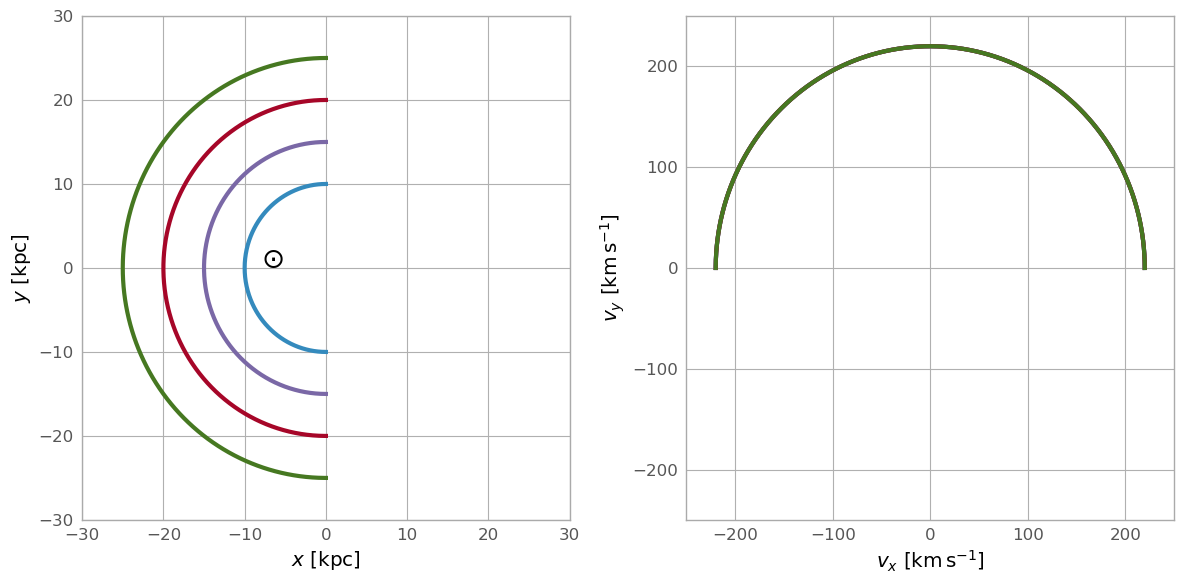

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

# Positions
axes[0].plot(gc_rings.x.T, gc_rings.y.T, marker = 'None', linewidth = 3)
axes[0].text(-8., 0, r'$\odot$', fontsize = 20)

axes[0].set_xlim(-30, 30)
axes[0].set_ylim(-30, 30)

axes[0].set_xlabel('$x$ [kpc]')
axes[0].set_ylabel('$y$ [kpc]')

# velocities
axes[1].plot(gc_rings.v_x.T, gc_rings.v_y.T, marker = 'None', linewidth = 3)

axes[1].set_xlim(-250, 250)
axes[1].set_ylim(-250, 250)

axes[1].set_xlabel(f"$v_x$ [{(u.km / u.s).to_string('latex_inline')}]")
axes[1].set_ylabel(f"$v_y$ [{(u.km / u.s).to_string('latex_inline')}]")

fig.tight_layout()

plt.show()

Now we can transform to Galactic coordinates and visualize the rings in observable coordinates:

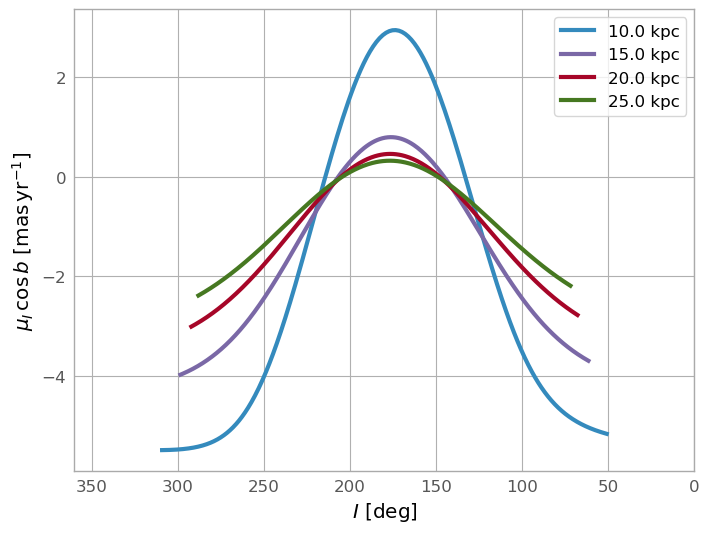

In [19]:
gal_rings = gc_rings.transform_to(coord.Galactic)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
for i in range(len(ring_distances)):
    ax.plot(gal_rings[i].l.degree, gal_rings[i].pm_l_cosb.value, 
            label = str(ring_distances[i]), marker = 'None', linewidth = 3)
    
ax.set_xlim(360, 0)

ax.set_xlabel('$I$ [deg]')
ax.set_ylabel(fr'$\mu_I\, \cos b$ [{(u.mas/u.yr).to_string("latex_inline")}]')

ax.legend()
              
plt.show()

---

## 4. Create a new coordinate class (for the Sagittarius stream)

This document describes in detail how to subclass and define a custom spherical coordinate frame, as discussed in Defining a New Frame and the docstring for BaseCoordinateFrame. In this example, we will define a coordinate system defined by the plane of orbit of the Sagittarius Dwarf Galaxy (hereafter Sgr; as defined in Majewski et al. 2003). The Sgr coordinate system is often referred to in terms of two angular coordinates, 
.

To do this, we need to define a subclass of BaseCoordinateFrame that knows the names and units of the coordinate system angles in each of the supported representations. In this case we support SphericalRepresentation with “Lambda” and “Beta”. Then we have to define the transformation from this coordinate system to some other built-in system. Here we will use Galactic coordinates, represented by the Galactic class.

**SEE ALSO**

> - The gala package, which defines a number of Astropy coordinate frames for stellar stream coordinate systems.
> - Majewski et al. 2003, “A Two Micron All Sky Survey View of the Sagittarius Dwarf Galaxy. I. Morphology of the Sagittarius Core and Tidal Arms”, https://arxiv.org/abs/astro-ph/0304198
> - Law & Majewski 2010, “The Sagittarius Dwarf Galaxy: A Model for Evolution in a Triaxial Milky Way Halo”, https://arxiv.org/abs/1003.1132
> - David Law’s Sgr info page https://www.stsci.edu/~dlaw/Sgr/

> By: Adrian Price-Whelan, Erik Tollerud

> License: BSD



Make print work the same in all versions of Python, set up numpy, matplotlib, and use a nicer set of plot parameters:

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)

Import the packages necessary for coordinates

In [21]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose, rotation_matrix

The first step is to create a new class, which we’ll call `Sagittarius` and make it a subclass of BaseCoordinateFrame:

In [23]:
class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the sagittarius dwarf galaxy, as described in 
        https://ui.adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        https://www.stsci.edu/~dlaw/Sgr/.
        
    Parameters
    ----------
    representation: '~astropy.coordinates.BaseRepresentation' or None
        A representation object or None to have no data (or use the other keywords)
    Lambda: '~astropy.coordinates.Angle', optional, must be keyword
        The longitude-like angle corresponding to Sagittarius orbit
    Beta: '~astropy.coordinates.Angle', optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : `~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : `~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : `~astropy.units.Quantity`, optional, keyword-only
        The radial velocity of this object.

    """
        
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential
    
    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }

Breaking this down line-by-line, we define the class as a subclass of BaseCoordinateFrame. Then we include a descriptive docstring. The final lines are class-level attributes that specify the default representation for the data, default differential for the velocity information, and mappings from the attribute names used by representation objects to the names that are to be used by the `Sagittarius` frame. In this case we override the names in the spherical representations but don’t do anything with other representations like cartesian or cylindrical.



Next we have to define the transformation from this coordinate system to some other built-in coordinate system; we will use Galactic coordinates. We can do this by defining functions that return transformation matrices, or by simply defining a function that accepts a coordinate and returns a new coordinate in the new system. Because the transformation to the Sagittarius coordinate system is just a spherical rotation from Galactic coordinates, we’ll just define a function that returns this matrix. We’ll start by constructing the transformation matrix using pre-determined Euler angles and the `rotation_matrix` helper function:

In [25]:
SGR_PHI = (180 +3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree

# Generate the rotation matrix using the x-convention (see Goldstein)
SGR_MATRIX = (
    np.diag([1., 1., -1])
    @ rotation_matrix(SGR_PSI, "z")
    @ rotation_matrix(SGR_THETA, "x")
    @ rotation_matrix(SGR_PHI, "z")
)

Since we already constructed the transformation (rotation) matrix above, and the inverse of a rotation matrix is just its transpose, the required transformation functions are very simple:

In [27]:
@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galatic_to_sgr():
    """
    Compute the transformat matrix from Galatic spherical to heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

The decorator `@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)` registers this function on the `frame_transform_graph` as a coordinate transformation. Inside the function, we simply return the previously defined rotation matrix.

We then register the inverse transformation by using the transpose of the rotation matrix (which is faster to compute than the inverse):

In [28]:
@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """
    Compute the transformation matrix from heliocentric Sgr coordinates to spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)

Now that we’ve registered these transformations between `Sagittarius` and Galactic, we can transform between any coordinate system and `Sagittarius` (as long as the other system has a path to transform to Galactic). For example, to transform from ICRS coordinates to `Sagittarius`, we would do:

In [29]:
icrs = coord.SkyCoord(280.161732*u.degree, 11.91934*u.degree, frame = 'icrs')
sgr = icrs.transform_to(Sagittarius)
print(sgr)

<SkyCoord (Sagittarius): (Lambda, Beta) in deg
    (346.81830652, -39.28360407)>


Or, to transform from the Sagittarius frame to ICRS coordinates (in this case, a line along the Sagittarius x-y plane):

In [30]:
sgr = coord.SkyCoord(Lambda = np.linspace(0, 2*np.pi, 128)*u.radian, 
                     Beta = np.zeros(128)*u.radian, frame = 'sagittarius')
icrs = sgr.transform_to(coord.ICRS)
print(icrs)

<SkyCoord (ICRS): (ra, dec) in deg
    [(284.03876751, -29.00408353), (287.24685769, -29.44848352),
     (290.48068369, -29.81535572), (293.7357366 , -30.1029631 ),
     (297.00711066, -30.30991693), (300.28958688, -30.43520293),
     (303.57772919, -30.47820084), (306.86598944, -30.43869669),
     (310.14881715, -30.31688708), (313.42076929, -30.11337526),
     (316.67661568, -29.82915917), (319.91143548, -29.46561215),
     (323.12070147, -29.02445708), (326.30034928, -28.50773532),
     (329.44683007, -27.9177717 ), (332.55714589, -27.257137  ),
     (335.62886847, -26.52860943), (338.66014233, -25.73513624),
     (341.64967439, -24.87979679), (344.59671212, -23.96576781),
     (347.50101283, -22.99629167), (350.36280652, -21.97464811),
     (353.18275454, -20.90412969), (355.96190618, -19.78802107),
     (358.70165491, -18.62958199), (  1.40369557, -17.43203397),
     (  4.06998374, -16.19855028), (  6.70269788, -14.93224899),
     (  9.30420479, -13.63618882), ( 11.87702861, -12.3

As an example, we’ll now plot the points in both coordinate systems:

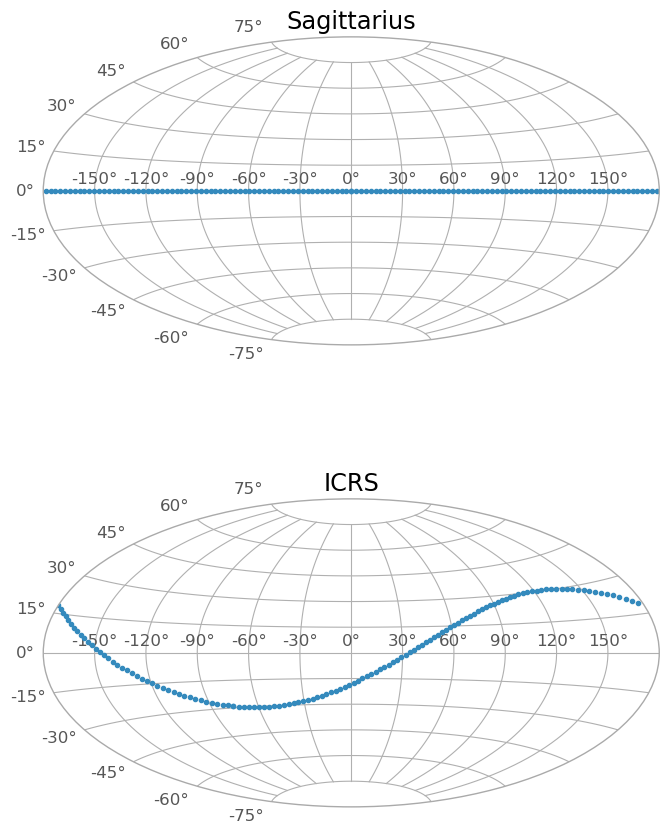

In [31]:
fig, axes = plt.subplots(2, 1, figsize = (8, 10),
                         subplot_kw = {'projection': 'aitoff'})

axes[0].set_title("Sagittarius")
axes[0].plot(sgr.Lambda.wrap_at(180*u.deg).radian, 
             sgr.Beta.radian, 
             linestyle = 'none', 
             marker=".")

axes[1].set_title("ICRS")
axes[1].plot(icrs.ra.wrap_at(180*u.deg).radian, 
             icrs.dec.radian,
             linestyle = 'none',
             marker = ".")

plt.show()

This particular transformation is just a spherical rotation, which is a special case of an Affine transformation with no vector offset. The transformation of velocity components is therefore natively supported as well:

<SkyCoord (ICRS): (ra, dec) in deg
    [(284.03876751, -29.00408353), (287.24685769, -29.44848352),
     (290.48068369, -29.81535572), (293.7357366 , -30.1029631 ),
     (297.00711066, -30.30991693), (300.28958688, -30.43520293),
     (303.57772919, -30.47820084), (306.86598944, -30.43869669),
     (310.14881715, -30.31688708), (313.42076929, -30.11337526),
     (316.67661568, -29.82915917), (319.91143548, -29.46561215),
     (323.12070147, -29.02445708), (326.30034928, -28.50773532),
     (329.44683007, -27.9177717 ), (332.55714589, -27.257137  ),
     (335.62886847, -26.52860943), (338.66014233, -25.73513624),
     (341.64967439, -24.87979679), (344.59671212, -23.96576781),
     (347.50101283, -22.99629167), (350.36280652, -21.97464811),
     (353.18275454, -20.90412969), (355.96190618, -19.78802107),
     (358.70165491, -18.62958199), (  1.40369557, -17.43203397),
     (  4.06998374, -16.19855028), (  6.70269788, -14.93224899),
     (  9.30420479, -13.63618882), ( 11.87702861, -12.3

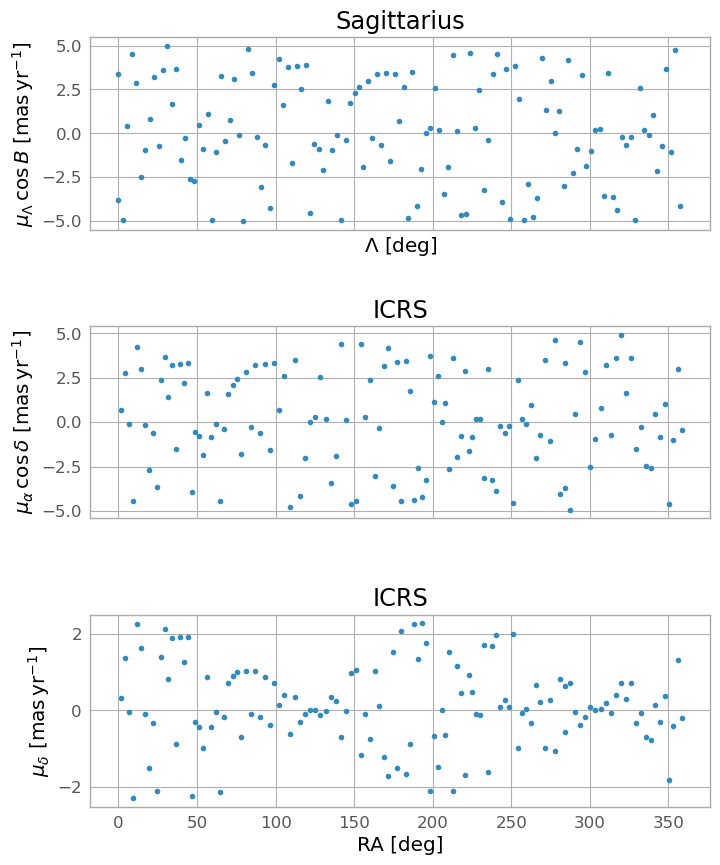

In [32]:
sgr = coord.SkyCoord(Lambda = np.linspace(0, 2*np.pi, 128)*u.radian,
                     Beta = np.zeros(128)*u.radian,
                     pm_Lambda_cosBeta = np.random.uniform(-5, 5, 128)*u.mas/u.yr,
                     pm_Beta = np.zeros(128)*u.mas/u.yr,
                     frame = 'sagittarius')
icrs = sgr.transform_to(coord.ICRS)
print(icrs)

fig, axes = plt.subplots(3, 1, figsize = (8, 10), sharex = True)

axes[0].set_title("Sagittarius")
axes[0].plot(sgr.Lambda.degree,
             sgr.pm_Lambda_cosBeta.value,
             linestyle = 'none',
             marker = '.')

axes[0].set_xlabel(r"$\Lambda$ [deg]")
axes[0].set_ylabel(
    fr"$\mu_\Lambda \, \cos B$ [{sgr.pm_Lambda_cosBeta.unit.to_string('latex_inline')}]")

axes[1].set_title("ICRS")
axes[1].plot(icrs.ra.degree, icrs.pm_ra_cosdec.value,
             linestyle='none', marker='.')
axes[1].set_ylabel(
    fr"$\mu_\alpha \, \cos\delta$ [{icrs.pm_ra_cosdec.unit.to_string('latex_inline')}]")

axes[2].set_title("ICRS")
axes[2].plot(icrs.ra.degree, icrs.pm_dec.value,
             linestyle='none', marker='.')
axes[2].set_xlabel("RA [deg]")
axes[2].set_ylabel(
    fr"$\mu_\delta$ [{icrs.pm_dec.unit.to_string('latex_inline')}]")

plt.show()



